In [17]:
import requests
import pandas as pd
import pickle
import json
from datetime import datetime
import matplotlib.pyplot as plt



%matplotlib inline

baseurl = 'https://thevirustracker.com/timeline/map-data.json'

countrycode = 'BR'

time_col = 'date'

max_forecast_date = '2020-07-25'

data_proc_file = '../../Data/Processed/covid19_data_modeling.parquet'
model_score_file = '../../Data/Modeling/model_scores.parquet'
model_file = '../../Data/Modeling/trained_models.jbl'


pd.plotting.register_matplotlib_converters()

# Carrega Modelos 

In [18]:
with open(model_file, 'rb') as fid:
    trained_models = pickle.load(fid)

trained_models.keys()

dict_keys(['US', 'CN', 'BR'])

# Carrega Tabela de Resultado da Modelagem 

In [19]:
df_models = pd.read_parquet(model_score_file)
df_models.head()

,countrycode,date_begin,date_end,model_name,score
0,US,2020-01-22,2020-04-30,prophet,0.927120
1,CN,2020-01-22,2020-04-30,prophet,0.564901
2,BR,2020-02-26,2020-04-30,prophet,21.179157


# Carrega Dados Atualizados 

In [20]:
data = pd.read_parquet(data_proc_file)

data = data[data[time_col] < max_forecast_date]
data = data[data.countrycode == countrycode].copy()

print('shape:', data.shape)
print('columns:', data.columns)

shape: (150, 5)
columns: Index(['cases', 'countrycode', 'date', 'deaths', 'recovered'], dtype='object')


# Previsão até a data retornada 

In [21]:
if countrycode not in trained_models.keys():
    raise Exception("Country code not found:" + countrycode)

model = trained_models[countrycode]
model_last_date = df_models[df_models.countrycode==countrycode].date_end.dt.date.values[0]
date_max = datetime.strptime(max_forecast_date, '%Y-%m-%d').date()

# Evaluate Model
n_periods = (date_max-model_last_date).days
forecast_data = model.make_future_dataframe(
    periods=n_periods,
    include_history=True
    )
df_forecast = model.predict(forecast_data).set_index('ds')
forecast     = df_forecast.yhat[-n_periods:].rename('forecast')
forecast_low  =  df_forecast.yhat_lower[-n_periods:].rename('forecast_lo')
forecast_up   =  df_forecast.yhat_upper[-n_periods:].rename('forecast_up')



# Plot da Previsão e do Real 

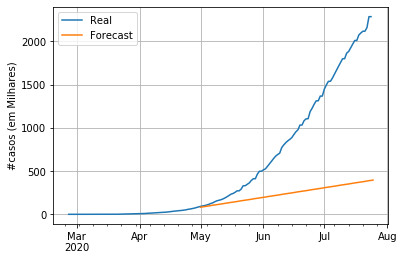

In [23]:
pd.plotting.register_matplotlib_converters()

(data.groupby(['date']).cases.sum() * 1e-3).plot(label='Real')
(forecast * 1e-3).plot(label='Forecast')
plt.legend()
plt.xlabel('')
plt.ylabel('#casos (em Milhares)')
plt.grid()
